# 0 - Import libraries

In [1]:
import itertools
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import statsmodels.api as sm
from catboost import CatBoostRegressor
from joblib import load
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")

# 1 - Import dataset

In [2]:
def check_data(df):
    if isinstance(df, pd.DataFrame):
        print(80 * "*")
        print("DIMENSION: ({}, {})".format(df.shape[0], df.shape[1]))
        print(80 * "*")
        print("COLUMNS:\n")
        print(df.columns.values)
        print(80 * "*")
        print("DATA INFO:\n")
        print(df.dtypes)
        print(80 * "*")
        print("MISSING VALUES:\n")
        print(df.isnull().sum())
        print(80 * "*")
        print("NUMBER OF UNIQUE VALUES:\n")
        print(df.nunique())

## 1.1 - Get Taxi dataset

In [3]:
df = pd.read_parquet(
    "nyc-dataset/data/dataset.parquet",
    engine="pyarrow",
)
df.dropna(inplace=True, axis=0)

In [4]:
df.tail(10)

,tpep_pickup_hour,location_id,trip_count,time,weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,rain_sum
1774154,2022-12-01 13:00:00,236,1,2022-12-01,3.0,8.6,0.9,3.8,0.0,0.0
1774155,2022-12-01 13:00:00,239,1,2022-12-01,3.0,8.8,1.1,4.0,0.0,0.0
1774156,2022-12-01 14:00:00,68,1,2022-12-01,3.0,9.3,1.2,4.2,0.0,0.0
1774157,2022-12-01 14:00:00,90,1,2022-12-01,3.0,9.2,1.2,4.1,0.0,0.0
1774158,2022-12-01 15:00:00,141,1,2022-12-01,3.0,8.7,1.0,3.9,0.0,0.0
1774159,2022-12-01 15:00:00,162,1,2022-12-01,3.0,8.4,0.7,3.6,0.0,0.0
1774160,2022-12-01 15:00:00,237,1,2022-12-01,3.0,8.7,1.0,3.9,0.0,0.0
1774161,2022-12-01 16:00:00,141,2,2022-12-01,3.0,8.7,1.0,3.9,0.0,0.0
1774162,2022-12-01 16:00:00,162,1,2022-12-01,3.0,8.4,0.7,3.6,0.0,0.0
1774163,2022-12-02 00:00:00,237,1,2022-12-02,1.0,5.5,-2.7,1.1,0.0,0.0


In [5]:
check_data(df)

********************************************************************************
DIMENSION: (1741045, 10)
********************************************************************************
COLUMNS:

['tpep_pickup_hour' 'location_id' 'trip_count' 'time' 'weathercode'
 'temperature_2m_max' 'temperature_2m_min' 'temperature_2m_mean'
 'precipitation_sum' 'rain_sum']
********************************************************************************
DATA INFO:

tpep_pickup_hour       datetime64[ns]
location_id                     int64
trip_count                      int64
time                           object
weathercode                   float64
temperature_2m_max            float64
temperature_2m_min            float64
temperature_2m_mean           float64
precipitation_sum             float64
rain_sum                      float64
dtype: object
********************************************************************************
MISSING VALUES:

tpep_pickup_hour       0
location_id            0
tr

# 2 - Modelling

## 2.1 - Time series model

In [ ]:
df_sarimax = df.copy()
df_sarimax = df_sarimax[df_sarimax["location_id"] == 132]
train, test = train_test_split(df_sarimax, shuffle=False, test_size=0.2)


def get_sarima_params(data, train_exog):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [
        (x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))
    ]
    result_list = []

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(
                    data,
                    exog=train_exog,
                    order=param,
                    seasonal_order=param_seasonal,
                    enforce_stationarity=False,
                    enforce_invertibility=True,
                )
                results = mod.fit(maxiter=2000)
                result_list.append(
                    {
                        "pda": param,
                        "seasonal_pda": param_seasonal,
                        "aic": results.aic,
                    }
                )
            except Exception as e:
                raise e

    if not result_list:
        raise ValueError("No valid SARIMA parameters found.")

    result_table = pd.DataFrame(result_list)
    optimal_params = result_table[
        result_table["aic"] == result_table.aic.min()
    ]
    order = optimal_params.pda.values[0]
    seasonal_order = optimal_params.seasonal_pda.values[0]
    return (order, seasonal_order)

In [ ]:
def apply_sarimax(
    train_data, train_exog, test_data, test_exog, order, seasonal_order
):
    print("SARIMAX MODEL ORDERS ARE = {} {} ".format(order, seasonal_order))

    mod = sm.tsa.statespace.SARIMAX(
        train_data, exog=train_exog, order=order, seasonal_order=seasonal_order
    )
    results = mod.fit()

    pred = results.get_prediction(
        start=train_data.index[0],
        end=train_data.index[-1],
        exog=train_exog,
        dynamic=False,
    )
    train_forecast = pred.predicted_mean.round()
    train_forecast[train_forecast < 0] = 0

    pred1 = results.get_prediction(
        start=test_data.index[0],
        end=test_data.index[-1],
        exog=test_exog,
        dynamic=False,
    )
    test_forecast = pred1.predicted_mean.round()
    test_forecast[test_forecast < 0] = 0
    return (train_forecast, test_forecast)


def print_sarima_results(train_data, test_data, train_forecast, test_forecast):
    plt.figure(figsize=(20, 8))
    plt.plot(train_data.index, train_data, label="Train")
    plt.plot(test_data.index, test_data, label="Test")
    plt.plot(train_forecast.index, train_forecast, label="Train Forecast")
    plt.plot(test_forecast.index, test_forecast, label="Test Forecast")
    plt.legend(loc="best")
    plt.show()
    train_actual = np.asarray(train_data)
    train_forecast = np.asarray(train_forecast)
    test_actual = np.asarray(test_data)
    test_forecast = np.asarray(test_forecast)
    # Find mape
    train_ape = np.abs((train_actual - train_forecast) / train_actual)
    test_ape = np.abs((test_actual - test_forecast) / test_actual)
    train_mape = np.mean(train_ape) * 100
    test_mape = np.mean(test_ape) * 100

    # Find rmsle
    train_log_actual = np.log1p(train_actual)
    train_log_forecast = np.log1p(train_forecast)

    test_log_actual = np.log1p(test_actual)
    test_log_forecast = np.log1p(test_forecast)

    train_square_diff = (train_log_actual - train_log_forecast) ** 2
    test_square_diff = (test_log_actual - test_log_forecast) ** 2

    train_mean_squared_diff = np.mean(train_square_diff)
    test_mean_squared_diff = np.mean(test_square_diff)

    train_rmsle = np.sqrt(train_mean_squared_diff)
    test_rmsle = np.sqrt(test_mean_squared_diff)

    print(
        "Train Mean Absolute Error:     ",
        mean_absolute_error(train_data, train_forecast),
    )
    print(
        "Train Root Mean Squared Error: ",
        np.sqrt(mean_squared_error(train_data, train_forecast)),
    )
    print("Train Mean Absolute Percentage Error:     ", train_mape)
    print("Train Root Mean Squared Log Error:        ", train_rmsle)
    print(
        "Test Mean Absolute Error:      ",
        mean_absolute_error(test_data, test_forecast),
    )
    print(
        "Test Root Mean Squared Error:  ",
        np.sqrt(mean_squared_error(test_data, test_forecast)),
    )
    print("Test Mean Absolute Percentage Error:     ", test_mape)
    print("Test Root Mean Squared Log Error:        ", test_rmsle)

In [ ]:
train_data = train["trip_count"].reset_index(drop=True)

train_exog = train.loc[
    :,
    [
        "temperature_2m_max",
        "temperature_2m_min",
        "temperature_2m_mean",
        "precipitation_sum",
        "rain_sum",
    ],
].reset_index(drop=True)

test_data = test["trip_count"].reset_index(drop=True)
test_exog = test.loc[
    :,
    [
        "temperature_2m_max",
        "temperature_2m_min",
        "temperature_2m_mean",
        "precipitation_sum",
        "rain_sum",
    ],
].reset_index(drop=True)

In [ ]:
order, seasonal_order = get_sarima_params(train_data, train_exog)
train_forecast, test_forecast = apply_sarimax(
    train_data, train_exog, test_data, test_exog, order, seasonal_order
)

In [ ]:
print_sarima_results(train_data, test_data, train_forecast, test_forecast)

## 2.2 - Regression model

In [6]:
df_for_reg = df.copy()

In [7]:
df_for_reg["location_id"] = [
    "location_id_" + str(int(x)).zfill(4)
    for x in df_for_reg["location_id"].values
]
df_for_reg["weathercode"] = [
    "weather_code_" + str(int(x)).zfill(4)
    for x in df_for_reg["weathercode"].values
]

In [8]:
df_for_reg["day_of_year"] = df_for_reg["tpep_pickup_hour"].dt.dayofyear
df_for_reg["day_of_month"] = df_for_reg["tpep_pickup_hour"].dt.day
df_for_reg["day_of_week"] = df_for_reg["tpep_pickup_hour"].dt.dayofweek
df_for_reg["is_weekend"] = [
    1 if x in [5, 6] else 0 for x in df_for_reg["day_of_week"].values
]
df_for_reg["year"] = df_for_reg["tpep_pickup_hour"].dt.year
df_for_reg["month"] = df_for_reg["tpep_pickup_hour"].dt.month
df_for_reg["hour"] = df_for_reg["tpep_pickup_hour"].dt.hour


# Sort the data by day of the year in ascending order
df_for_reg = df_for_reg.sort_values(by=["tpep_pickup_hour"])

# Drop datetime column
df_for_reg = df_for_reg.drop(["time", "tpep_pickup_hour"], axis=1)

In [9]:
df_for_reg.head()

,location_id,trip_count,weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,rain_sum,day_of_year,day_of_month,day_of_week,is_weekend,year,month,hour
0,location_id_0004,2,weather_code_0053,4.6,-3.1,1.1,1.0,1.0,1,1,4,0,2021,1,0
57,location_id_0179,1,weather_code_0053,4.4,-3.0,0.8,1.0,1.0,1,1,4,0,2021,1,0
56,location_id_0173,1,weather_code_0053,4.3,-3.1,0.7,0.9,0.9,1,1,4,0,2021,1,0
55,location_id_0170,8,weather_code_0053,4.5,-3.3,0.9,1.0,1.0,1,1,4,0,2021,1,0
54,location_id_0169,1,weather_code_0053,4.3,-3.2,0.6,1.0,1.0,1,1,4,0,2021,1,0


## 2.2.1 - Create sliding window

In [10]:
def create_sliding_window(df, window_size):
    # Sort the data to ensure chronological order within each group
    tmp_data = df.copy()
    tmp_data = tmp_data.sort_values(
        ["location_id", "day_of_year", "hour"], ascending=True
    )

    # Apply sliding window to create new columns within each group
    grouped = tmp_data.groupby("location_id")
    for i in range(1, window_size + 1):
        col_name = f"trip_count_backward_{i}"
        tmp_data[col_name] = grouped["trip_count"].shift(i)

    # Remove the first rows within each group that contain NaN values due to shifting
    tmp_data = (
        tmp_data.groupby("location_id")
        .apply(lambda x: x.iloc[window_size:])
        .reset_index(drop=True)
    )
    return tmp_data


df_for_reg = create_sliding_window(df_for_reg, 7)
df_for_reg.head()

,location_id,trip_count,weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,rain_sum,day_of_year,day_of_month,...,year,month,hour,trip_count_backward_1,trip_count_backward_2,trip_count_backward_3,trip_count_backward_4,trip_count_backward_5,trip_count_backward_6,trip_count_backward_7
0,location_id_0001,7,weather_code_0055,12.8,9.0,10.3,6.8,6.8,1,1,...,2022,1,14,1.0,3.0,1.0,7.0,1.0,1.0,2.0
1,location_id_0001,8,weather_code_0055,12.8,9.0,10.3,6.8,6.8,1,1,...,2022,1,15,7.0,1.0,3.0,1.0,7.0,1.0,1.0
2,location_id_0001,10,weather_code_0055,12.8,9.0,10.3,6.8,6.8,1,1,...,2022,1,16,8.0,7.0,1.0,3.0,1.0,7.0,1.0
3,location_id_0001,3,weather_code_0055,12.8,9.0,10.3,6.8,6.8,1,1,...,2022,1,17,10.0,8.0,7.0,1.0,3.0,1.0,7.0
4,location_id_0001,1,weather_code_0055,12.8,9.0,10.3,6.8,6.8,1,1,...,2022,1,18,3.0,10.0,8.0,7.0,1.0,3.0,1.0


In [11]:
y = df_for_reg["trip_count"]
X_cat = df_for_reg.drop(["trip_count"], axis=1)
X_num = pd.get_dummies(X_cat, drop_first=True)
X_train_cat, X_test_cat, y_train, y_test = train_test_split(
    X_cat, y, test_size=0.2, shuffle=False
)
X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_num, y, test_size=0.2, shuffle=False
)

# Store the splitted data
if not os.path.exists("data/processed"):
    os.makedirs("data/processed")
with open("data/processed/cat.pkl", "wb") as f:
    pickle.dump((X_train_cat, X_test_cat, y_train, y_test), f)
with open("data/processed/num.pkl", "wb") as f:
    pickle.dump((X_train_num, X_test_num, y_train, y_test), f)

In [13]:
# Define the regressors
regressors = {
    "CatBoost": CatBoostRegressor(
        cat_features=["location_id", "weathercode"],
        iterations=1000,
        learning_rate=0.1,
        verbose=0,
    ),
    "XGBRegressor": XGBRegressor(),
    "RandomForestRegressor": RandomForestRegressor(n_estimators=20, n_jobs=-1),
}

# Create the pipelines
pipelines = []
for regressor_name, regressor in regressors.items():
    pipeline = Pipeline([(regressor_name, regressor)])
    pipelines.append(pipeline)

# Train and evaluate the pipelines
results = []
for idx, pipeline in enumerate(pipelines):
    regressor_name = "_".join(list(pipeline.named_steps.keys()))
    print(f"Training and evaluating Pipeline {idx+1}: {regressor_name}...")

    if regressor_name == "CatBoost":
        # Fit the pipeline to the training data
        pipeline.fit(X_train_cat, y_train)

        # Make predictions on the train and test data
        train_pred = pipeline.predict(X_train_cat)
        test_pred = pipeline.predict(X_test_cat)
    else:
        # Fit the pipeline to the training data
        pipeline.fit(X_train_num, y_train)

        # Make predictions on the train and test data
        train_pred = pipeline.predict(X_train_num)
        test_pred = pipeline.predict(X_test_num)

    # Store the pipeline
    if not os.path.exists("data/models"):
        os.makedirs("data/models")
    with open(f"data/models/{regressor_name}.pkl", "wb") as f:
        pickle.dump(pipeline, f)

    # Calculate evaluation metrics
    train_mae = mean_absolute_error(y_train, train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    train_ape = np.abs((y_train - train_pred) / y_train)
    train_mape = np.mean(train_ape) * 100

    test_mae = mean_absolute_error(y_test, test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    test_ape = np.abs((y_test - test_pred) / y_test)
    test_mape = np.mean(test_ape) * 100

    # Calculate RMSLE
    train_rmsle = np.sqrt(
        np.mean((np.log1p(y_train) - np.log1p(train_pred)) ** 2)
    )
    test_rmsle = np.sqrt(
        np.mean((np.log1p(y_test) - np.log1p(test_pred)) ** 2)
    )

    # Store the results
    results.append(
        {
            "Pipeline": regressor_name,
            "Train MAE": train_mae,
            "Train RMSE": train_rmse,
            "Train MAPE": train_mape,
            "Train RMSLE": train_rmsle,
            "Test MAE": test_mae,
            "Test RMSE": test_rmse,
            "Test MAPE": test_mape,
            "Test RMSLE": test_rmsle,
        }
    )

# Display the results
results_df = pd.DataFrame(results)

Training and evaluating Pipeline 1: CatBoost...
Training and evaluating Pipeline 2: XGBRegressor...
Training and evaluating Pipeline 3: RandomForestRegressor...


In [14]:
results_df

,Pipeline,Train MAE,Train RMSE,Train MAPE,Train RMSLE,Test MAE,Test RMSE,Test MAPE,Test RMSLE
0,CatBoost,5.103079,10.613764,46.503349,0.373687,17.980025,32.466774,67.235588,0.788658
1,XGBRegressor,5.102990,10.410122,49.441491,0.380290,10.630640,20.283713,42.934687,0.390765
2,RandomForestRegressor,1.953024,4.413968,16.171341,0.152790,10.632502,20.388465,36.444995,0.369841


# 3 - Results Analysis

In [2]:
with open("data/processed/cat.pkl", "rb") as f:
    X_train_cat, X_test_cat, y_train, y_test = pickle.load(f)
with open("data/processed/num.pkl", "rb") as f:
    X_train_num, X_test_num, y_train, y_test = pickle.load(f)

In [3]:
Model_CatBoost = load("data/models/CatBoost.pkl")
Model_RandomForestRegressor = load("data/models/RandomForestRegressor.pkl")
Model_XGBRegressor = load("data/models/XGBRegressor.pkl")

In [4]:
# CatBoostRegressor feature importances
catboost_model = Model_CatBoost.named_steps["CatBoost"]
catboost_importances = catboost_model.feature_importances_

# Get the indices of the top 5 features
catboost_top5_indices = np.argsort(catboost_importances)[::-1][:5]

print("Top 5 most important features for CatBoostRegressor:")
for idx in catboost_top5_indices:
    feature = X_train_cat.columns[idx]
    importance = catboost_importances[idx]
    print(f"{feature}: {importance}")

# XGBRegressor feature importances
xgb_model = Model_XGBRegressor.named_steps["XGBRegressor"]
xgb_importances = xgb_model.feature_importances_

# Get the indices of the top 5 features
xgb_top5_indices = np.argsort(xgb_importances)[::-1][:5]

print("\nTop 5 most important features for XGBRegressor:")
for idx in xgb_top5_indices:
    feature = X_train_num.columns[idx]
    importance = xgb_importances[idx]
    print(f"{feature}: {importance}")

# RandomForestRegressor feature importances
rf_model = Model_RandomForestRegressor.named_steps["RandomForestRegressor"]
rf_importances = rf_model.feature_importances_

# Get the indices of the top 5 features
rf_top5_indices = np.argsort(rf_importances)[::-1][:5]

print("\nTop 5 most important features for RandomForestRegressor:")
for idx in rf_top5_indices:
    feature = X_train_num.columns[idx]
    importance = rf_importances[idx]
    print(f"{feature}: {importance}")

Top 5 most important features for CatBoostRegressor:
trip_count_backward_2: 66.12216909806608
hour: 13.084926426777248
trip_count_backward_1: 6.407949180520504
location_id: 3.3381896864739
trip_count_backward_6: 1.9896383389349002

Top 5 most important features for XGBRegressor:
trip_count_backward_2: 0.735602080821991
location_id_location_id_0079: 0.02071552164852619
hour: 0.016482826322317123
trip_count_backward_1: 0.01410991046577692
location_id_location_id_0148: 0.01065821573138237

Top 5 most important features for RandomForestRegressor:
trip_count_backward_2: 0.9151018961704902
hour: 0.027472418841568206
trip_count_backward_1: 0.006512907028024786
trip_count_backward_6: 0.005717502623903032
trip_count_backward_4: 0.0050819940101988455


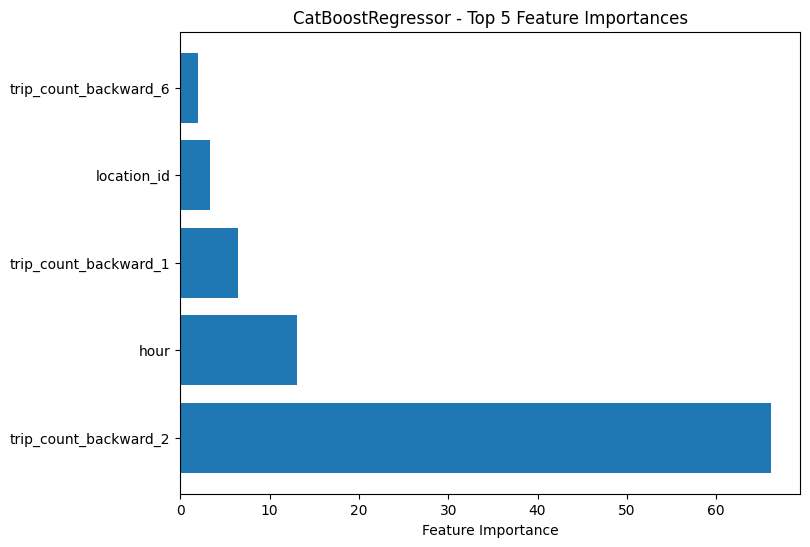

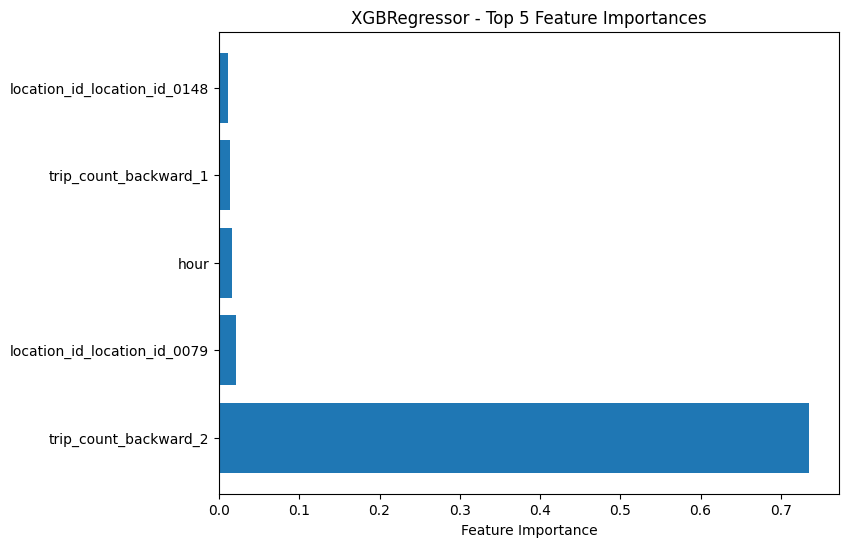

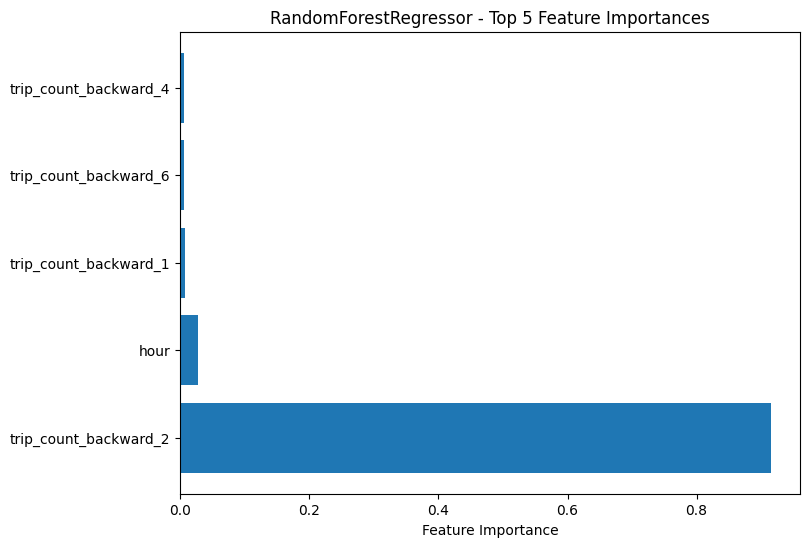

In [5]:
# CatBoostRegressor feature importances
catboost_model = Model_CatBoost.named_steps["CatBoost"]
catboost_importances = catboost_model.feature_importances_

# Get the indices of the top 5 features
catboost_top5_indices = np.argsort(catboost_importances)[::-1][:5]

# Get the top 5 feature names and importances
catboost_top5_features = X_train_cat.columns[catboost_top5_indices]
catboost_top5_importances = catboost_importances[catboost_top5_indices]

# Create the bar plot for CatBoostRegressor
plt.figure(figsize=(8, 6))
plt.barh(
    range(len(catboost_top5_features)),
    catboost_top5_importances,
    align="center",
)
plt.yticks(range(len(catboost_top5_features)), catboost_top5_features)
plt.xlabel("Feature Importance")
plt.title("CatBoostRegressor - Top 5 Feature Importances")
plt.show()

# XGBRegressor feature importances
xgb_model = Model_XGBRegressor.named_steps["XGBRegressor"]
xgb_importances = xgb_model.feature_importances_

# Get the indices of the top 5 features
xgb_top5_indices = np.argsort(xgb_importances)[::-1][:5]

# Get the top 5 feature names and importances
xgb_top5_features = X_train_num.columns[xgb_top5_indices]
xgb_top5_importances = xgb_importances[xgb_top5_indices]

# Create the bar plot for XGBRegressor
plt.figure(figsize=(8, 6))
plt.barh(range(len(xgb_top5_features)), xgb_top5_importances, align="center")
plt.yticks(range(len(xgb_top5_features)), xgb_top5_features)
plt.xlabel("Feature Importance")
plt.title("XGBRegressor - Top 5 Feature Importances")
plt.show()

# RandomForestRegressor feature importances
rf_model = Model_RandomForestRegressor.named_steps["RandomForestRegressor"]
rf_importances = rf_model.feature_importances_

# Get the indices of the top 5 features
rf_top5_indices = np.argsort(rf_importances)[::-1][:5]

# Get the top 5 feature names and importances
rf_top5_features = X_train_num.columns[rf_top5_indices]
rf_top5_importances = rf_importances[rf_top5_indices]

# Create the bar plot for RandomForestRegressor
plt.figure(figsize=(8, 6))
plt.barh(range(len(rf_top5_features)), rf_top5_importances, align="center")
plt.yticks(range(len(rf_top5_features)), rf_top5_features)
plt.xlabel("Feature Importance")
plt.title("RandomForestRegressor - Top 5 Feature Importances")
plt.show()

In [6]:
# Create the pipelines with loaded models
pipelines = [
    ("CatBoost", Model_CatBoost, X_train_cat, X_test_cat),
    (
        "RandomForestRegressor",
        Model_RandomForestRegressor,
        X_train_num,
        X_test_num,
    ),
    ("XGBRegressor", Model_XGBRegressor, X_train_num, X_test_num),
]

# Train and evaluate the pipelines
results = []
for regressor_name, pipeline, X_train, X_test in pipelines:
    print(f"Evaluating Pipeline: {regressor_name}...")

    # Make predictions on the train and test data
    if regressor_name == "CatBoost":
        train_pred = pipeline.predict(X_train)
        test_pred = pipeline.predict(X_test)
    else:
        train_pred = pipeline.predict(X_train_num)
        test_pred = pipeline.predict(X_test_num)

    # Calculate evaluation metrics
    train_mae = mean_absolute_error(y_train, train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    train_ape = np.abs((y_train - train_pred) / y_train)
    train_mape = np.mean(train_ape) * 100

    test_mae = mean_absolute_error(y_test, test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    test_ape = np.abs((y_test - test_pred) / y_test)
    test_mape = np.mean(test_ape) * 100

    # Calculate RMSLE
    train_rmsle = np.sqrt(
        np.mean((np.log1p(y_train) - np.log1p(train_pred)) ** 2)
    )
    test_rmsle = np.sqrt(
        np.mean((np.log1p(y_test) - np.log1p(test_pred)) ** 2)
    )

    # Calculate MOP and MUP
    train_diff = train_pred - y_train
    test_diff = test_pred - y_test

    mop_train = np.mean(np.maximum(train_diff, 0))
    mop_test = np.mean(np.maximum(test_diff, 0))

    mup_train = np.mean(np.minimum(train_diff, 0))
    mup_test = np.mean(np.minimum(test_diff, 0))

    # Store the results
    results.append(
        {
            "Pipeline": regressor_name,
            "Train MAE": train_mae,
            "Test MAE": test_mae,
            "Train RMSE": train_rmse,
            "Test RMSE": test_rmse,
            "Train MAPE": train_mape,
            "Test MAPE": test_mape,
            "Train RMSLE": train_rmsle,
            "Test RMSLE": test_rmsle,
            "Train MOP": mop_train,
            "Test MOP": mop_test,
            "Train MUP": mup_train,
            "Test MUP": mup_test,
        }
    )

# Display the results
results_df = pd.DataFrame(results)

Evaluating Pipeline: CatBoost...
Evaluating Pipeline: RandomForestRegressor...
Evaluating Pipeline: XGBRegressor...


In [7]:
results_df.transpose()

,0,1,2
Pipeline,CatBoost,RandomForestRegressor,XGBRegressor
Train MAE,5.103079,1.953024,5.10299
Test MAE,17.980025,10.632502,10.63064
Train RMSE,10.613764,4.413968,10.410122
Test RMSE,32.466774,20.388465,20.283713
Train MAPE,46.503349,16.171341,49.441491
Test MAPE,67.235588,36.444995,42.934687
Train RMSLE,0.373687,0.15279,0.38029
Test RMSLE,0.788658,0.369841,0.390765
Train MOP,2.571882,0.994603,2.551493
